# Correlated Preferences Simluation
### Tyler Hoppenfeld

This notebook is intended to explore the of idiosynchratic preferences on market behavior.

There are several research questions that seem to be derrivitave of this, in varying degrees of being well-formed:

1. How do we define "idiosynchratic preferences?"
2. How does our definition of idiosynchratic prefernces scale with market size?
3. What do idiosynchratic preferences mean for stable latice size?
4. What are the welfare implications of idiosynchratic preferences?
5. What is the result of a case where both sides have idiosynchratic preferences, but the preferences are correlated between sides (ie, if $M_i$ ranks $W_j$ unusually highly, then $W_j$ also ranks $M_i$ unusually highly)?
6. How do these market structures interact with limited-length rank lists?

This notebook proposes an ad-hoc answer to 1 and 2, and uses a simulation to hint at the answer to 3. 

To answer 1, I construct a standard marriage market with $N$ participants on each side, indexed ${M_1, M_2, ..., M_N, W_1, W_2,..., W_N}$

I next construct preferences in which all particpents are mutually acceptable.  I begin by assigning a utility to each matching based on the participant's index number, so each man gets $1$ unit of utility from being matched to $W_1$, $ 2$ units from being matched to $W_2$, and so on up to $N$ units of utility from being matched to $W_N$.  This process gives $2 \times N \times N$ utility values.

I then add a perturbation to each utility value.  The perturbation is drawn from  $N(0, \sigma \bar{U})$ where $\bar{U}$ is the average utility for that economy and $\sigma$ is the parameter that controlls the degree to which preferences are idiosynchratic.

To produce the final complete preference, I sort by these utilities.


Note two things:
* this structure assumes an answer the question of what it means to hold idiosynchracy constant while scaling the market.  
* expanding the economy in this model is equivilent to adding new entrants to the market without expanding the difference in utility from being matched to one's favorite or least-prefered partner

After constructing these preferences I use a 3rd-party python package to implement the Gale-Shaply algorythm twice, once with men proposing and once with women proposing.  

As a proxy for latice size, and following Al Roth's heuristic used in class, I calculate the fraction of agents who have a different partner in the man-optimal matching than in the woman-optimal matchng.


This procedure constitutes a simulation of the economy.  I simulate each $N/\sigma$ pair 100 times, averaging the results, and tabulate them below.

### Scroll to "Main Results" to bypass the code:

In [1]:
#Import packages used below

from matching.algorithms import galeshapley
import operator
import random
from IPython.core.debugger import set_trace
import numpy as np
import pandas as pd
import multiprocess as mp 
import matplotlib.pyplot as plt



In [2]:
#Set parameters 
#note that the parameters for N and sigma are set below within a program.
#This is bad form, but I don't know how to do it correctly, so i'm documenting the bad practice here.

runs = 1000

In [3]:

#define simulation function that implements the process outlined in the text above
def GS_Sim(
    n ,
    sigma_fraction 
):
    #make randomly assigned preferences
    Mpref = {}
    Wpref = {}
    
    #scale sigma
    sigma = sigma_fraction * n /2
    for i in range(0, n):
        utility = []
        for x in range(0,n):
            id = 'W' + str(x)
            utility = utility + [(id, random.normalvariate(x, sigma))]
        utility.sort(key=operator.itemgetter(1))

        ranklist = []
        for x in utility:
            name = [x[0]]
            ranklist = ranklist + name
        id = 'M' + str(i)
        Mpref.update({id:ranklist})

    #copypasta from above
    for i in range(0, n):
        utility = []
        for x in range(0,n):
            id = 'M' + str(x)
            utility = utility + [(id, random.normalvariate(x, sigma))]
        utility.sort(key=operator.itemgetter(1))

        ranklist = []
        for x in utility:
            name = [x[0]]
            ranklist = ranklist + name
        id = 'W' + str(i)
        Wpref.update({id:ranklist})

    #Run matching
    M_propose= galeshapley(Mpref, Wpref)
    W_propose = galeshapley(Wpref, Mpref)

    #transform matchings into same-format list of tuples
    M_propose = list(M_propose.items())
    W_propose = [(v, k) for k, v in W_propose.items()]

    #sort matchings
    M_propose.sort(key=operator.itemgetter(0))
    W_propose.sort(key=operator.itemgetter(0))
    M_propose
    #Find % differences
    differences = (np.array(M_propose) == np.array(W_propose))

    percent_diff = np.average(differences, axis = 0).item(1)
    
    next_result = (n, sigma_fraction, percent_diff)
    return next_result
    




In [4]:
# an intermediate simulation program to allow me to parallelize the calculations
def simulate(x):
    #Note that, as noted above, I define the parameters here, within a program. This is bad.
    #Also note that the code in this block changes a bit as I add to the "results" object without 
    #re-running the entire simulation
    sizes = [10, 50, 500]
    sigmas = [.001, .01, .1, .3]
    #Slopyness ends here
    
    result = []
    for n in sizes:
        for sigma_fraction in sigmas:
            result =result + [GS_Sim(n, sigma_fraction)]
    return result



#Call the simulation 'runs' times and combine the results into a big list
with mp.Pool(8) as p:
    results4 = p.map(simulate, range(runs))

results = results1 + results2 +results3+results4

NameError: name 'results1' is not defined

In [11]:

#flatten the list:

def flatten(l):
  out = []
  for item in l:
    if isinstance(item, (list)):
      out.extend(flatten(item))
    else:
      out.append(item)
  return out

flat_results = flatten(results) 

#Take group averages within the simulation
simulation_results = pd.DataFrame(flat_results,columns=['Market Size', 'Sigma','% Commonality' ])

gb = simulation_results.groupby(['Market Size','Sigma'])['% Commonality' ]

simulation_results['Commonality SD'] = gb.transform('std')
simulation_results['Simulation Count'] = gb.transform('count')
deliverable = simulation_results.groupby(['Market Size','Sigma'])['% Commonality' , 'Commonality SD', 'Simulation Count'].mean().reset_index()



## Main Results:
The averaged results from the runs of this simulation for each parameter pair are plotted below. This suggests that there is not an obviously simple relationship between preference structure, market size, and the size of the core.

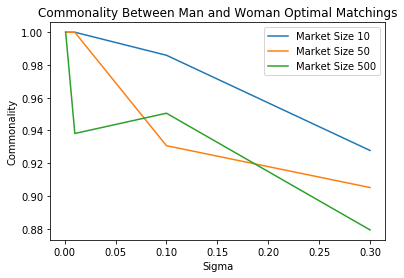

In [12]:
deliverable_10 = deliverable[deliverable['Market Size'] == 10]
deliverable_50 = deliverable[deliverable['Market Size'] == 50]
deliverable_500 = deliverable[deliverable['Market Size'] == 500]

plt.plot('Sigma', '% Commonality', data = deliverable_10, label = "Market Size 10")
plt.plot('Sigma', '% Commonality', data = deliverable_50, label = "Market Size 50")
plt.plot('Sigma', '% Commonality', data = deliverable_500, label = "Market Size 500")

plt.title("Commonality Between Man and Woman Optimal Matchings")
plt.xlabel('Sigma')
plt.ylabel('Commonality')
plt.legend()
plt.show()


### Data Structure Plot
To examine the structure of the data for the most interesting datapoints (size = 500, $\sigma$ = .01, .1), I form a histogram at those datapoints.  The averages do not appear to be driven by outliers, and they appear to have a similar data structure.

Text(0.5,1,'Distribution of Comonalities for Size = 500, Sigma = .01')

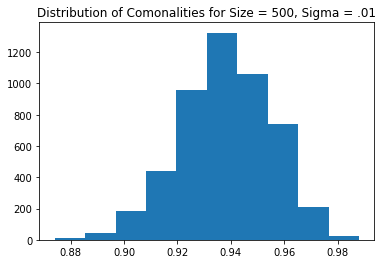

In [13]:
plt.hist(simulation_results[(simulation_results['Market Size']== 500 ) &(simulation_results['Sigma']== .01 )]['% Commonality'])
plt.title("Distribution of Comonalities for Size = 500, Sigma = .01")



Text(0.5,1,'Distribution of Comonalities for Size = 500, Sigma = .1')

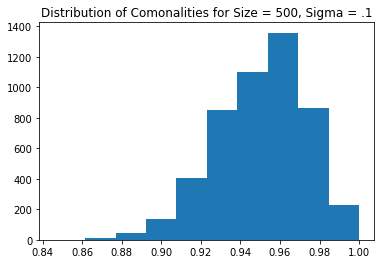

In [14]:
plt.hist(simulation_results[(simulation_results['Market Size']== 500 ) &(simulation_results['Sigma']== .1 )]['% Commonality'])
plt.title("Distribution of Comonalities for Size = 500, Sigma = .1")

## Granular results:
Finally, I show the basic summary statistics underlying the first plot:

In [10]:
deliverable

,Market Size,Sigma,% Commonality,Commonality SD,Simulation Count
0,10,0.001,1.000000,0.000000,5000
1,10,0.010,1.000000,0.000000,5000
2,10,0.100,0.985940,0.052885,5000
3,10,0.300,0.927780,0.124344,5000
4,50,0.001,1.000000,0.000000,5000
5,50,0.010,0.999968,0.001131,5000
6,50,0.100,0.930704,0.057844,5000
7,50,0.300,0.905140,0.076464,5000
8,500,0.001,0.999974,0.000319,5000
9,500,0.010,0.938159,0.016932,5000
